In [1]:
!pip install torchinfo

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
#set workdir
os.chdir("/content/gdrive/My Drive/Projects/MSc-Project-River-Segmentation/MSc-Project/Code")

dataset_dir = os.path.normpath("/content/gdrive/My Drive/Data/sentinel-river-segmentation-dataset/sentinel-river-segmentation-dataset")


In [4]:
! ls


config.cfg     Evaluation.ipynb  Predict.ipynb	state_dict.pth	test.jpeg
dataloader.py  models		 __pycache__	Testing.ipynb	Training.ipynb


In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from dataloader import Dataset
from torchinfo import summary
import time
import copy

from tqdm import tqdm

from models.unet import UNet
from models.simple import Simple

from dataloader import Dataset

In [6]:
def process(images_fps):

    image_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
            ])
    
    image = cv2.imread(images_fps)
    image = cv2.resize(image, (416, 416), interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image_transform(image)

    return image

In [7]:
import matplotlib.pyplot as plt
def plot_side_by_side(rgb,ground_truth,predict):
    assert rgb.shape[0] == ground_truth.shape[0] == predict.shape[0]
    batch_size = rgb.shape[0]
    print(batch_size)
    fig, axs = plt.subplots(batch_size, 3, figsize=(30,30))
    for i in range(batch_size):
        axs[i, 0].imshow(rgb[i])
        axs[i, 1].imshow(ground_truth[i])
        axs[i, 2].imshow(predict[i])



In [8]:
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

def reverse_transform(inp):
    #print(inp.shape)
    inp = inv_normalize(inp)
    inp = inp.numpy()
    inp = np.swapaxes(inp, 1, 3)
    inp = np.swapaxes(inp, 1, 2)
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

In [9]:
def labels2mask(labels):
    return labels[:,1,:,:]

In [10]:
from models.vgg_unet import VggUnet

def makePrediction (input_image):

    model = VggUnet()
    model.load_state_dict(torch.load("state_dict.pth", map_location="cpu"))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    #image = cv2.imread(input_image) 

    p_image = process(input_image)
    p_image = p_image.reshape(1,3,416,416)
    #print(p_image.shape)    
    
    p_image = p_image.to(device)

    pred = model(p_image)
    pred = torch.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    p_image = p_image.data.cpu()


    # dataloader return normalized input image, so we have to denormalize before viewing
    input_images = reverse_transform(p_image)
    # target and predict mask are single channel, so squeeze

    pred = labels2mask(pred)
    print(pred.shape)

    # use helper function to plot
    #plot_side_by_side(input_images, target_masks, pred)

    #plt.imshow(input_images) 
    print(input_images.shape)
  
    assert input_images.shape[0] == pred.shape[0] #
    batch_size = input_images.shape[0]
    #print(batch_size)
    fig, axs = plt.subplots(batch_size, 2, figsize=(30,30))
    for i in range(batch_size):
        axs[ 0].imshow(input_images[i])
        axs[ 1].imshow(pred[i])
    

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [11]:
makePrediction("test.jpeg")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Evaluation.ipynb
	modified:   Training.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add .

In [ ]:
!git commit -m "updated"
!git config --global user.email "moad.s.k@gmail.com"
!git config --global user.name "MoadSaadKhorchef"

[main 09c4a3c] updated
 2 files changed, 2 insertions(+), 2 deletions(-)
 rewrite Code/Evaluation.ipynb (90%)


In [ ]:
!git push origin main

Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 622.69 KiB | 10.38 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/MoadSaadKhorchef/MSc-Project.git
   b4ee1f1..09c4a3c  main -> main


In [31]:
PARAMS = {
    "input_size": 416,
    "output_size": 416,
    "model": "vgg_unet",
    "learning_rate": 0.001,
    "n_classes": 2,

    
}

In [32]:
x_train_dir = os.path.join(dataset_dir,"x_train")
y_train_dir = os.path.join(dataset_dir,"y_train")
x_test_dir = os.path.join(dataset_dir,"x_test")
y_test_dir = os.path.join(dataset_dir,"y_test")

In [33]:
train_set = Dataset(x_train_dir, y_train_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS["n_classes"])
test_set = Dataset(x_test_dir, y_test_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS["n_classes"])

batch_size = 8
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [35]:
from models.vgg_unet import VggUnet


model = VggUnet()
model.load_state_dict(torch.load("state_dict.pth", map_location="cpu"))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [79]:
import matplotlib.pyplot as plt
def plot_side_by_side(rgb,ground_truth,predict):
    assert rgb.shape[0] == ground_truth.shape[0] == predict.shape[0]
    batch_size = rgb.shape[0]
    #print(batch_size)
    fig, axs = plt.subplots(1, 3, figsize=(30,30))
    for i in range(batch_size):
        axs[ 0].imshow(rgb[i])
        axs[ 1].imshow(ground_truth[i])
        axs[ 2].imshow(predict[i])

(1, 416, 416, 3)
(1, 416, 416)


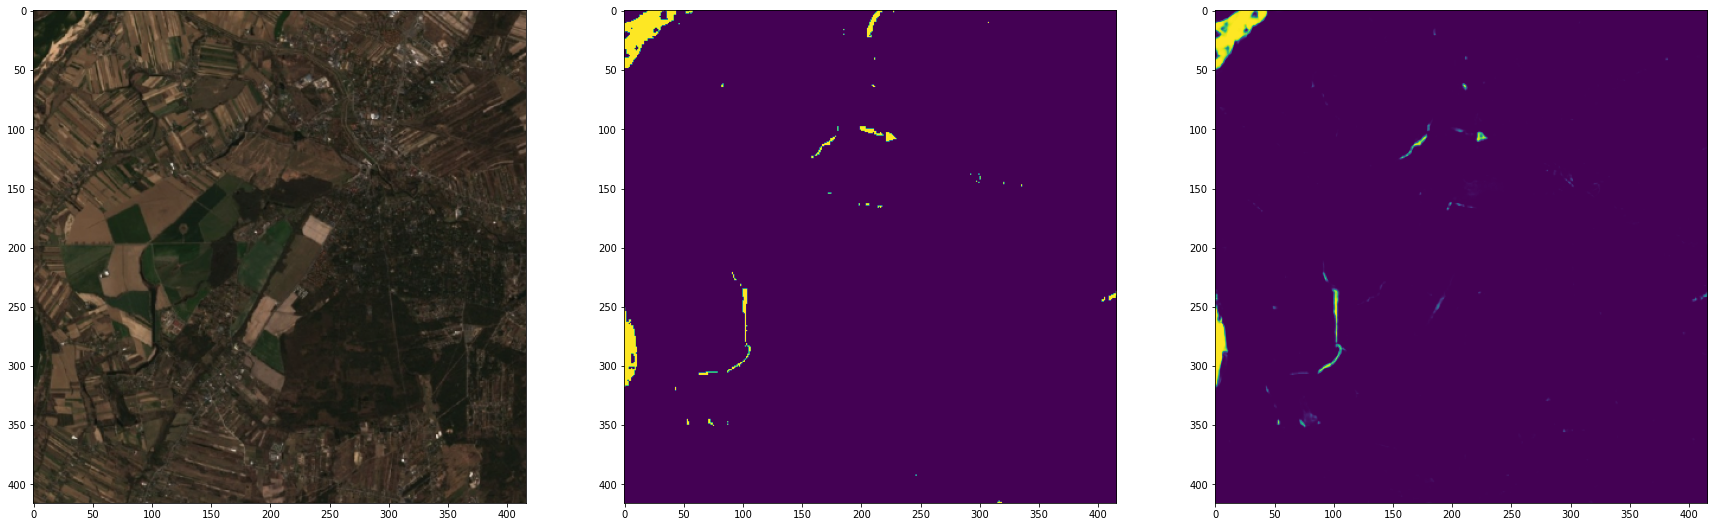

In [81]:
import math
model.eval()   # Set model to evaluate mode

test_dataset = Dataset(x_test_dir, y_test_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS["n_classes"])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)


inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
labels = labels.data.cpu().numpy()

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
inputs = inputs.data.cpu()

#print(inputs.shape)
#print(labels)
#print(torch.sigmoid(torch.from_numpy(pred)).round())

# dataloader return normalized input image, so we have to denormalize before viewing
input_images = reverse_transform(inputs)
# target and predict mask are single channel, so squeeze
target_masks = labels2mask(labels)

pred = labels2mask(pred)

print(input_images.shape)
print(pred.shape)

# use helper function to plot
plot_side_by_side(input_images, target_masks, pred)


In [76]:
pred.shape

(1, 416, 416)

In [77]:
input_images.shape

(1, 416, 416, 3)